# ❓👥 Tag suggestion 3: Training+storing final model

|   |   |
|---|---|
| Project  |    [Catégorisez automatiquement des questions](#https://openclassrooms.com/fr/paths/148/projects/111/assignment)         |
| Date   |   March 2023   |
| Autor  | Ana Bernal                                                    |
| Data source | [StackExchange Data Explorer](https://data.stackexchange.com/stackoverflow/query/new) |
| Mentor | Samir Tanfous | 
| Notebook number  | 3 of 4                                                    |

**Description:** In this notebook we take a sample of 50 000 questions posted in the platform [stack overflow](https://stackoverflow.com/), we embed them using Universal Sentence Encoder and we train a Naive Bayes Multinomial classifier, which is stored for use in an API.

Table of contents:
- [Libraries](#Libraries)
- [Functions](#Functions)
- [Load Data](#Load-Data)
- [Import embedding](#Import-embedding)
- [Finding best parameters](#Finding-best-parameters)
      - [Evaluation: NaiveBayes](#Evaluation:-NaiveBayes)
- [Train best model on all data](#Train-best-model-on-all-data)
- [Save model](#Save-model)

# Libraries

In [28]:
# built in
import time
from itertools import cycle # for cycling through colors

# data and linear algebra
import numpy as np
import pandas as pd

# graphics & visualization
import seaborn as sns
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.sklearn

# model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

# metrics
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score

# sklearn NLP
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation


# Functions

The following cell contains the functions that we use in this notebook.

In [55]:
def choose_best_thres(y_true, y_pred_proba):
    '''
    Returns a threshold between 0.1 and 0.9
    which maximizes the macro average f1-score,
    for a multilabel classification problem.

    Parameters:
        - y_true: binary array
        - y_pred_proba: array
            returned by some_estimator.predict_proba()
    '''
    f1_thr = {}
    for t in np.linspace(0.1,0.9,9): # testing thresholds 0.2, 0.3, up to 0.8
        classif_rep = classification_report(
            y_true, 
            (y_pred_proba > t).astype(int),
            target_names=tag_list,
            output_dict=True,
            zero_division=0)
        f1_thr[t] =  classif_rep['macro avg']['f1-score']

    # choose threshold for maximal f1-score
    thresh = round(max(f1_thr, key=f1_thr.get),1)
    print(f'Threshold that maximizes f1-score: {thresh}')

    return thresh


def plot_classif_report(classif_report, tag_list, model_name, dataset_name, vectorization):
    '''
    Plots precision, recall and f1-score for each tag in tag_list.

    Parameters:
        - classif_report: dict
            It is the output of sklearn.metrics.classification_report(y_true,y_pred)
            after a multi-label multi-output classification.
        - tag_list: list of str
            The list of tags of the classification.
        - model_name, dataset_name: str
            for the title of the plot
    '''
    global f1_sco
    n_tags = len(tag_list)

    fig = plt.figure(figsize=(10, 6))
    plt.grid(True)
    plt.xticks(range(1,len(tag_list)+1),tag_list)
    colors = ['blueviolet', 'darkorange', 'dodgerblue']

    for metric,color in zip(['precision', 'recall', 'f1-score'], colors):
        y = [classif_report[tag][metric] for tag in tag_list]
        plt.scatter(range(1,n_tags+1),y,label=metric, c=color)
    plt.legend()
    plt.ylim(0,1.1)
    plt.xticks(rotation=70)

    macro_prec = round(classif_report['macro avg']['precision'],2)
    macro_rec = round(classif_report['macro avg']['recall'],2)
    macro_f1 = round(classif_report['macro avg']['f1-score'],2)
    f1_sco = macro_f1

    plt.text(30, 
             0.05, 
             f'Macro avg\nprecision: {macro_prec}\nrecall: {macro_rec}\nf1-score: {macro_f1}',
             bbox={'facecolor':'white', 'alpha':0.5})
    plt.title(f'Some metrics by tag\nModel: {model_name}, set: {dataset_name}, vectorization: {vectorization}')
    plt.show()

def diplay_and_plot_report(y_true, y_pred, model_name, dataset_name, vectorization):
        '''
        Displays the classification report together with the metrics
        (from the mul-label, multi-output classification) and plots
        the metrics for each tag.

        Parameters:
                - y_true: array
                        The true labels
                - y_pred: array
                        The prefictions
                - model_name, dataset_name: str
                        For the title of the plot
        '''

        classif_rep = classification_report(
                y_true, 
                y_pred,
                target_names=tag_list,
                output_dict=True,
                zero_division=0)
        classif_rep_displ = classification_report(
                y_true, 
                y_pred,
                target_names=tag_list,
                output_dict=False,
                zero_division=0)
        print(f'Classifier: {model_name}\tDataset: {dataset_name}')
        print('-'*70)
        print(classif_rep_displ)
        plot_classif_report(classif_rep, tag_list, model_name, dataset_name, vectorization)

def compute_roc_data(y_true,y_pred_proba,tag_list):
    '''
    Computes the data necessary to plot the OneVsRest
    ROC curves of our multilabel classification.
    Returns dictionnaries: fpr, tpr, roc_auc

    Based on sckikit-learn's example: 
    https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py

    Parameters:
        - y_true: pd.DataFrame
        - y_pred: array
            returned by classification: predict probabilities
        - tag_list: list of str 
    '''
    global roc_auc_res

    n_tags = len(tag_list)
    # store the fpr, tpr, and roc_auc for all averaging strategies
    fpr, tpr, roc_auc = dict(), dict(), dict()

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.values.ravel(), y_pred_proba.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")


    for i in range(n_tags):
        fpr[i], tpr[i], _ = roc_curve(y_true.values[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr_grid = np.linspace(0.0, 1.0, 1000)

    # Interpolate all ROC curves at these points
    mean_tpr = np.zeros_like(fpr_grid)

    for i in range(n_tags):
        mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

    # Average it and compute AUC
    mean_tpr /= n_tags

    fpr["macro"] = fpr_grid
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    roc_auc_res = roc_auc["macro"]

    print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

    return fpr, tpr, roc_auc



def plot_roc_curves(
        fpr, tpr, roc_auc, model_name, dataset_name, vector_name,y_true,y_pred_proba):
    '''
    Plots the ROC curves of the OneVsRest classification
    for each tag.

    Based on scikit-learn's example:
    https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py

    Parameters:
        - fpr, tpr, roc_auc: dict, dict, dict
            Output of the function compute_roc_data
        - model_name, dataset_name: str
            For the title of the plot
    '''
    

    fig, ax = plt.subplots(figsize=(6, 6))

    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
        color="deeppink",
        linestyle=":",
        linewidth=3,
    )

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
        color="navy",
        linestyle=":",
        linewidth=3,
    )

    
    colors = cycle(sns.color_palette("hls", 40))
    for (idx,class_id), color in zip(enumerate(tag_list), colors):
        RocCurveDisplay.from_predictions(
            y_true[f'tag_{class_id}'].values,
            y_pred_proba[:, idx],
            name=f"ROC curve for {class_id}",
            color=color,
            ax=ax,
        )

    plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC curves and AUC for each tag to One-vs-Rest\nmodel: {model_name}, dataset: {dataset_name},\n vectorizarion: {vector_name}")
    plt.legend(loc='center left', bbox_to_anchor = (1,0.5))
    plt.show()

def plot_LDA_scores(param_results):
    """
    Plots the silhouette score and Calinski-Harabasz score
    obtained from param_search_LDA
    """

    # Plotting the results from the previous grid
    fig = plt.figure(figsize=(10,4))
    sns.set_style("whitegrid")

    # axis for silhouette score
    ax = fig.add_subplot(1,2,1)
    sns.set_style("whitegrid")
    sns.lineplot(
        data = param_results,
        x = 'n_components',
        y = 'Silhouette score',
        marker='o',
        color='purple'
    )
    ax.set_xlabel('Number of topics')


    # axis for Calinski-Harabasz score
    ax = fig.add_subplot(1,2,2)
    sns.lineplot(
    data = param_results,
    x = 'n_components',
    y = 'Calinski-Harabasz score',
    marker='o',
    color='dodgerblue'
    )
    ax.set_xlabel('Number of topics')

    # Setting titles and displaying
    plt.suptitle(f'Metrics for different number of topics. LDA')
    plt.tight_layout()
    plt.show()

def param_search_LDA(X_tfidf, a, b): # 10, 31
    """
    Performs a parameter search for LDA,
    testing values for n_components in the range
    from 10 to 30.

    Parameters:

    - X_norm: np.array. It is the feature matrix, normalized.
    """

    # Specify parameters and
    n_components_range =  range(a,b),

    # Storing results
    result_grid = {
        'n_components' : [],
        'Silhouette score' : [],
        'Calinski-Harabasz score' : []
    }
    i = 0

    # Loop over parameters
    for comp in range(a,b):
        print(i)
        i += 1
        # Creating model and fitting
        lda_tfidf = LatentDirichletAllocation(n_components=comp,
                                              random_state=0)
        lda_tfidf.fit(X_tfidf)
        topic_assignments = lda_tfidf.transform(X_tfidf)
        labels = np.argmax(topic_assignments, axis=1)
        # Appending model metrics to the results
        result_grid['n_components'].append(comp)
        result_grid['Silhouette score'].append(
            silhouette_score(topic_assignments,labels).round(2)
            )
        result_grid['Calinski-Harabasz score'].append(
            calinski_harabasz_score(topic_assignments,labels)
        )

    
    # Display results
    result_grid_df = pd.DataFrame(result_grid)
    result_grid_df.set_index('n_components', inplace=True)
    
    return result_grid_df

def count_empty_LDA(X_tfidf, a, b): 
    """
    Performs a parameter search for LDA,
    testing values for n_components in the range
    from 10 to 30.
    It counts the number of topics empty suggested tag with LDA.

    Parameters:

    - X_norm: np.array. It is the feature matrix, normalized.
    """

    # Specify parameters and
    n_components_range =  range(a,b),

    # Storing results
    result_grid = {
        'n_components' : [],
        'n_empty_tag_topic' : [],
    }

    # Loop over parameters
    for comp in range(a,b):
        print(comp)
        # Creating model and fitting
        lda_tfidf = LatentDirichletAllocation(n_components=comp,
                                              random_state=0)
        lda_tfidf.fit(X_tfidf)
        topic_assignments = lda_tfidf.transform(X_tfidf)
        labels = np.argmax(topic_assignments, axis=1)
        # Appending model metrics to the results
        result_grid['n_components'].append(comp)

        # Creating list of 30 most popular words per topic
        words_topic = {}
        for index,topic in enumerate(lda_tfidf.components_):
            words_topic[index] = [tfidf.get_feature_names()[i] for i in topic.argsort()[-30:]]

        # Intersect this list with our tag official tag list
        topics_tags = {}
        for topic in words_topic:
            topics_tags[topic] = list(set(words_topic[topic]).intersection(tag_list))

        for key,value in topics_tags.items():
            print(f'Topic # {key}, Tags: {value}')

        # Counting empty tag set
        number_empty_tag_topic = 0
        for key,value in topics_tags.items():
            if len(value) == 0:
                number_empty_tag_topic += 1

        # Appending model metrics to the results
        result_grid['n_empty_tag_topic'].append(number_empty_tag_topic)
    
    # Display results
    result_grid_df = pd.DataFrame(result_grid)
    result_grid_df.set_index('n_components', inplace=True)
    
    return result_grid_df


# Load Data

In [3]:
path = './data/'
# path = './drive/MyDrive/colab-notebooks/'  # When in colab
filename = 'processed_data_v011.csv'

df = pd.read_csv(path + filename)
df.set_index('Id', inplace=True)

tag_list = [tag[4:] for tag in list(df.columns) if 'tag' in tag]

In [4]:
df.shape

(40166, 46)

# Import embedding

In [5]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

2023-03-02 14:11:01.415451: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-02 14:11:02.495008: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-02 14:11:02.495045: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-02 14:11:05.403706: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [6]:
def feature_USE_fct(sentences, b_size):
    batch_size = b_size
    time1 = time.time()

    nb_batches = (len(sentences)//batch_size) +1

    for step in range(nb_batches):
        idx = step*batch_size

        if step == nb_batches - 1:  # last batch is smaller
            batch_size = len(sentences)%10  # residue modulo 10
        
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0:
            features = feat
        else:
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    print(f'Processing time: {time2 - time1} ')
    return features

In [7]:
import time

In [8]:
batch_size = 10
sentences = df['processed_text'].to_list()
features_USE = feature_USE_fct(sentences, batch_size)

Processing time: -1677763097.5336175 


In [9]:
len(sentences)

40166

In [10]:
features_USE.shape

(40166, 512)

In [14]:
y.shape

(40166, 38)

In [34]:
y_pred.shape

NameError: name 'y_pred' is not defined

In [18]:
len(sentences)

40166

We can now obtain our **feature matrix**:

In [12]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Finding best parameters

In [19]:
X = features_USE

# Defining target vector
columns_tags = ['tag_'+tag for tag in tag_list]
y = df[columns_tags]

# Scaling data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Splitting into train and test set
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,y, test_size=0.33, random_state=5
)

We now do a random search for the best parameters

In [25]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB


from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score


In [21]:
parameters = {
    'estimator__alpha' : [0.05, 0.2, 0.5, 1],
    'estimator__fit_prior' : [True, False]
}

# Instantiating OneVsRest Classifier
cl = OneVsRestClassifier(MultinomialNB())

# Grid search for best hyperparameters
grid_search = GridSearchCV(
    estimator = cl,
    param_grid= parameters,
    scoring='roc_auc_ovr',
    verbose=2,
    n_jobs=-1
)

# Performing grid search
grid_search.fit(X_train, y_train)

# Instantiating Best OneVsRest Classifier
cl = grid_search.best_estimator_

# Fitting classifier
start = time.time()
cl.fit(X_train,y_train)
finish = time.time()
fittime = finish - start
print(f'fit time: {fittime} secs.')

# Predicting (with probabilites)
start = time.time()
y_pred_train_proba = cl.predict_proba(X_train)
finish = time.time()
print(f'predict time: {finish - start} secs.')

y_pred_test_proba = cl.predict_proba(X_test)

# Print best parameters
print('The best parameters are:')
best_params = grid_search.best_params_
print(grid_search.best_params_)
print('The best score is:')
print(grid_search.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END ..estimator__alpha=0.05, estimator__fit_prior=False; total time=  24.7s
[CV] END ...estimator__alpha=0.05, estimator__fit_prior=True; total time=  24.9s
[CV] END ..estimator__alpha=0.05, estimator__fit_prior=False; total time=  25.1s
[CV] END ..estimator__alpha=0.05, estimator__fit_prior=False; total time=  25.9s
[CV] END ...estimator__alpha=0.05, estimator__fit_prior=True; total time=  25.9s
[CV] END ...estimator__alpha=0.05, estimator__fit_prior=True; total time=  29.9s
[CV] END ...estimator__alpha=0.05, estimator__fit_prior=True; total time=  30.0s
[CV] END ...estimator__alpha=0.05, estimator__fit_prior=True; total time=  31.4s
[CV] END ....estimator__alpha=0.2, estimator__fit_prior=True; total time=  17.7s
[CV] END ....estimator__alpha=0.2, estimator__fit_prior=True; total time=  18.1s
[CV] END ..estimator__alpha=0.05, estimator__fit_prior=False; total time=  23.1s
[CV] END ..estimator__alpha=0.05, estimator__fit_

In [67]:
best_params = grid_search.best_params_

In [56]:
# Choosing best threshold for classification
thresh = choose_best_thres(y_train, y_pred_train_proba)

# predictions based on threshold
y_pred_train = (y_pred_train_proba > thresh).astype(int)
y_pred_test = (y_pred_test_proba > thresh).astype(int)

Threshold that maximizes f1-score: 0.4


#### Evaluation: NaiveBayes

Classifier: MultinomialNB	Dataset: train
----------------------------------------------------------------------
                precision    recall  f1-score   support

            c#       0.65      0.63      0.64      3955
          java       0.82      0.56      0.67      3611
    javascript       0.60      0.71      0.65      3202
        python       0.89      0.71      0.79      2977
           c++       0.62      0.73      0.67      2537
           ios       0.58      0.72      0.65      2218
       android       0.67      0.73      0.70      1925
          .net       0.41      0.47      0.44      2023
          html       0.46      0.73      0.56      1483
           php       0.75      0.69      0.72      1340
   objective-c       0.35      0.57      0.44      1176
        jquery       0.49      0.77      0.60      1187
             c       0.33      0.69      0.44      1084
        iphone       0.35      0.66      0.46      1030
           sql       0.46      0.80      0.59  

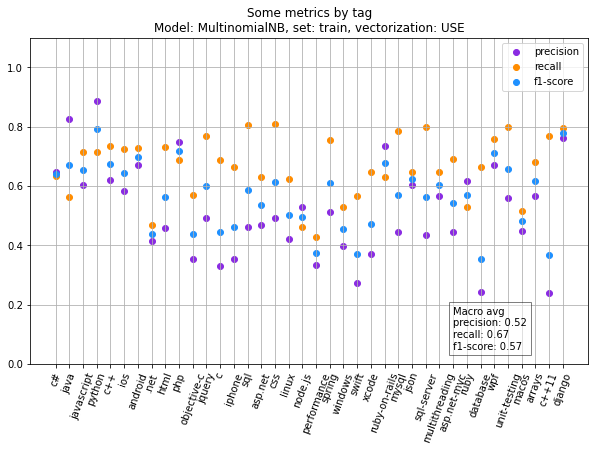

In [57]:
diplay_and_plot_report(y_train, 
                       y_pred_train, 
                       'MultinomialNB', 
                       'train',
                       'USE')

Classifier: MultinomialNB	Dataset: test
----------------------------------------------------------------------
                precision    recall  f1-score   support

            c#       0.65      0.64      0.65      1984
          java       0.83      0.58      0.68      1734
    javascript       0.59      0.70      0.64      1510
        python       0.91      0.71      0.80      1545
           c++       0.61      0.72      0.66      1235
           ios       0.59      0.73      0.65      1113
       android       0.66      0.70      0.68       977
          .net       0.41      0.45      0.43      1039
          html       0.42      0.73      0.53       645
           php       0.75      0.66      0.70       611
   objective-c       0.36      0.58      0.45       590
        jquery       0.47      0.74      0.57       544
             c       0.31      0.66      0.42       502
        iphone       0.33      0.59      0.42       527
           sql       0.43      0.77      0.55   

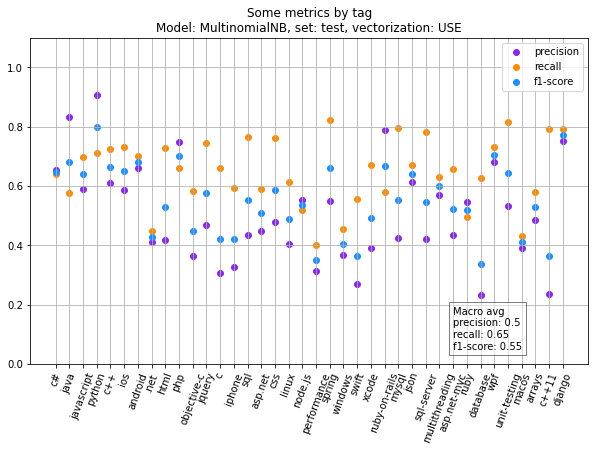

In [58]:
diplay_and_plot_report(y_test, 
                       y_pred_test, 
                       'MultinomialNB', 
                       'test',
                       'USE')

In [59]:
fpr, tpr, roc_auc = compute_roc_data(y_train,
                                     y_pred_train_proba, 
                                     tag_list)

Micro-averaged One-vs-Rest ROC AUC score:
0.96
Macro-averaged One-vs-Rest ROC AUC score:
0.96


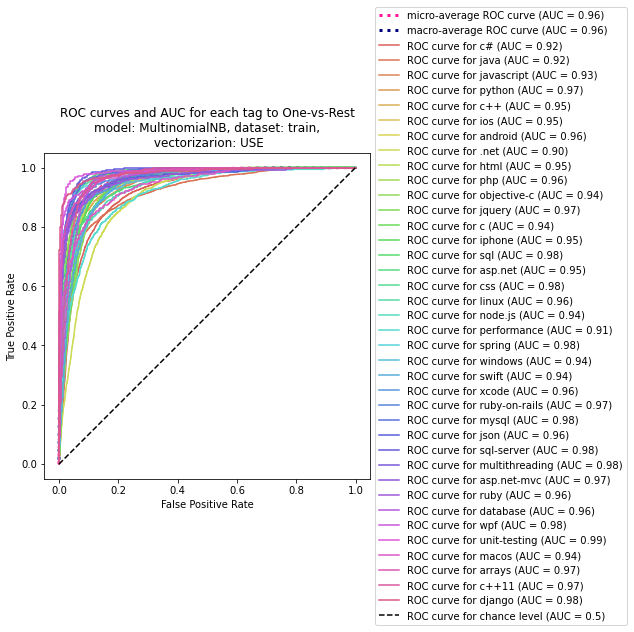

In [60]:
plot_roc_curves(fpr,
                tpr,
                roc_auc,
                'MultinomialNB', 
                'train',
                'USE',
                y_train, 
                y_pred_train_proba)

In [61]:
fpr, tpr, roc_auc = compute_roc_data(y_test,
                                     y_pred_test_proba, 
                                     tag_list)

Micro-averaged One-vs-Rest ROC AUC score:
0.96
Macro-averaged One-vs-Rest ROC AUC score:
0.95


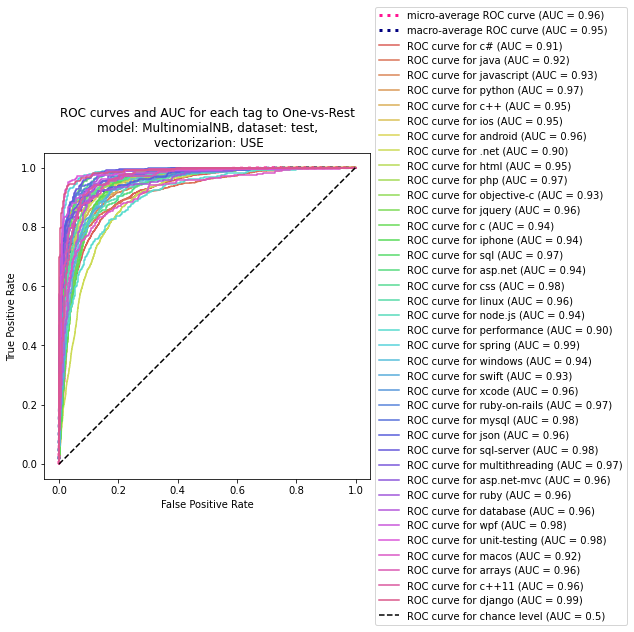

In [62]:
plot_roc_curves(fpr,
                tpr,
                roc_auc,
                'MultinomialNB', 
                'test',
                'USE',
                y_test, 
                y_pred_test_proba)

# Train best model on all data

In [68]:
best_params

{'estimator__alpha': 1, 'estimator__fit_prior': True}

In [71]:
# Instantiating Best OneVsRest Classifier
cl = OneVsRestClassifier(MultinomialNB(alpha=1, fit_prior=True))

# Fitting classifier
cl.fit(X_scaled,y)

# Save model

In [75]:
from joblib import dump, load

path = './trained_models/'
filename_model = 'multinomialNB-use.joblib'
filename_scaler = 'scaler.joblib'

dump(cl, path + filename_model)
dump(scaler, path + filename_scaler)

['./trained_models/scaler.joblib']